<a href="https://colab.research.google.com/github/adampotton/Cognitive_AI_CW/blob/main/Q2A_LSTM_BI_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adpating the LSTM model cost function to tackle sparsity

In [ ]:
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

In [2]:
import neurogym as ngym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import time

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:396: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Define a simple LSTM model

In [3]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_lstm_layers = 2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_lstm_layers) # n LSTM layers
        self.fc = nn.Linear(hidden_size, output_size) # Fully connected layer

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        out = self.fc(lstm_output)
        return out, lstm_output

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creating dataset and adjusting parameters

In [26]:
config = {
    'dt': 200, # Timestep parameter
    'hidden_size': 32, # Hidden size for your LSTM
    'batch_size': 32, # Batch size for training
    'seq_len': 50, # Sequence length for input data
    'envid': 'ReadySetGo-v0', # Task name
    'gain': 2, # Custom gain
    'prod_margin': 10, # Custom production margin
}

env_kwargs = {
    'dt': config['dt'], # Assing timestep parameter
    'gain': config['gain'],  # Controls the measure that the agent has to produce
    'prod_margin': config['prod_margin'], # Controls the interval around the ground truth production time within which the agent receives proportional reward
}
config['env_kwargs'] = env_kwargs

dataset = ngym.Dataset(config['envid'], env_kwargs=config['env_kwargs'], batch_size=config['batch_size'], seq_len=config['seq_len']) # Generate dataset
env = dataset.env

inputs, target = dataset() # Assing inputs and targets
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0] # Find dimensions for data
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

Input has shape (SeqLen, Batch, Dim) = torch.Size([50, 32, 3])
Target has shape (SeqLen, Batch) = (50, 32)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


### Training the model

In [58]:
iter_steps = 3000 # Training loops
report_freq = 100 # How often a report on is returned
l1_beta = 0.1 # Sparsity control

net = LSTMNet(input_size, config['hidden_size'], output_size, num_lstm_layers = 2) # Create an instance of the LSTM

def train_model(net, dataset, iter_steps, report_freq, l1_beta):

    optimizer = optim.Adam(net.parameters(), lr=0.0003) # Adam optimiser
    criterion = nn.CrossEntropyLoss() # Loss funciton

    running_loss = 0
    running_acc = 0
    losses = []
    accuracies = []
    start_time = time.time() # Start training timer

    for i in range(iter_steps):  # Loop over training batches
        inputs, labels = dataset()  # Generate a set of data
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        optimizer.zero_grad()  # Reset gradients
        output, _ = net(inputs)
        output = output.view(-1, output_size)
        loss = criterion(output, labels)  # Calculate loss


        l1_reg = 0 # Initialise the L1 Regularisation term
        for param in net.parameters(): # Extract all weight matrices from the network
            if param.requires_grad: # ensure that regularisation is only applied to trainable parts of the model
                l1_reg += torch.sum(torch.abs(param)) # Sum the matrices
        loss = criterion(output, labels) + l1_beta * l1_reg # Define new modified loss funciton
        loss.backward()
        optimizer.step()  # Update weights

        batch_acc = (torch.argmax(output, dim=1) == labels).sum().item() / labels.shape[0]  # Current batch accuracy
        losses.append(loss.item())
        accuracies.append(batch_acc)

        if i % report_freq == report_freq - 1:
            running_loss = sum(losses[-report_freq:]) / report_freq
            running_acc = sum(accuracies[-report_freq:]) / report_freq
            print('Step {}, Loss {:0.4f}, Accuracy {:0.4f}, Time {:0.1f}s'.format(
                i + 1, running_loss, running_acc, time.time() - start_time))
            running_loss = 0 # Reset metrics for next report
            running_acc = 0
    return net, losses, accuracies

net, losses, accuracies = train_model(net, dataset, iter_steps, report_freq, l1_beta) # Call the training function

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Step 100, Loss 99.0448, Accuracy 0.0378, Time 1.6s
Step 200, Loss 66.0508, Accuracy 0.7206, Time 3.2s
Step 300, Loss 39.8104, Accuracy 0.9624, Time 6.5s
Step 400, Loss 20.3349, Accuracy 0.9623, Time 8.3s
Step 500, Loss 7.5476, Accuracy 0.9622, Time 9.9s
Step 600, Loss 1.4930, Accuracy 0.9623, Time 11.4s
Step 700, Loss 0.6502, Accuracy 0.9623, Time 13.0s
Step 800, Loss 0.6354, Accuracy 0.9623, Time 14.6s
Step 900, Loss 0.6231, Accuracy 0.9624, Time 16.2s
Step 1000, Loss 0.6113, Accuracy 0.9624, Time 18.2s
Step 1100, Loss 0.6002, Accuracy 0.9623, Time 20.4s
Step 1200, Loss 0.5895, Accuracy 0.9624, Time 22.0s
Step 1300, Loss 0.5793, Accuracy 0.9625, Time 23.6s
Step 1400, Loss 0.5698, Accuracy 0.9625, Time 25.2s
Step 1500, Loss 0.5608, Accuracy 0.9624, Time 26.8s
Step 1600, Loss 0.5525, Accuracy 0.9622, Time 28.4s
Step 1700, Loss 0.5444, Accuracy 0.9624, Time 30.2s
Step 1800, Loss 0.5369, Accuracy 0.9624, Time 32.9s
Step 1900, Loss 0.5299, Accuracy 0.9623, Time 34.9s
Step 2000, Loss 0.5233

### Measuring the sparsity

In [61]:
sparsity = 0
total_params = 0
for param in net.parameters():
    if param.requires_grad:
        total_params += param.numel()
        sparsity += torch.sum(param <= 0.0000001).item()

sparsity_ratio = sparsity / total_params
print('Sparsity ratio:', sparsity_ratio)

Sparsity ratio: 0.5021132075471698


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Peformance Metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


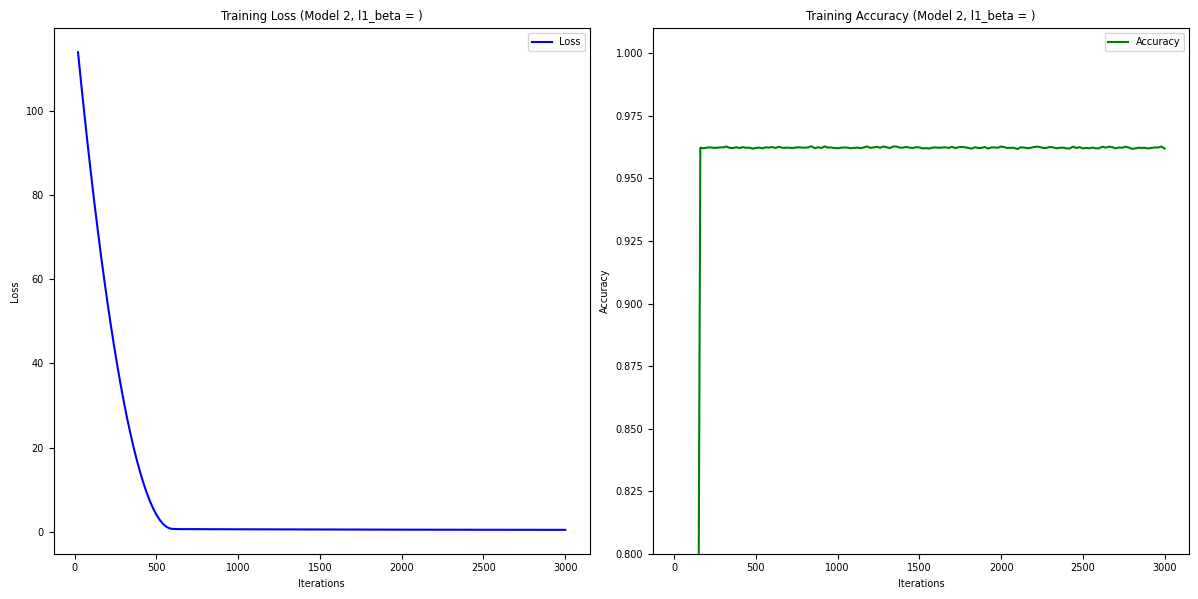

In [66]:
avg_losses = []
avg_accuracies = []
report_freq = 20
for i in range(report_freq - 1, len(losses), report_freq):
    avg_losses.append(sum(losses[i-report_freq+1:i+1]) / report_freq)
    avg_accuracies.append(sum(accuracies[i-report_freq+1:i+1]) / report_freq)

iterations = range(report_freq, len(losses) + 1, report_freq)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(iterations, avg_losses, label='Loss', color='blue')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss (Model 2, l1_beta = )')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(iterations, avg_accuracies, label='Accuracy', color='green')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.01)
plt.title('Training Accuracy (Model 2, l1_beta = )')
plt.legend()

plt.tight_layout()
plt.show()

In [39]:
env = dataset.env # Reset environment
env.reset(no_step=True)

for i in range(500):
    test_inputs, test_labels = dataset()
    test_inputs = torch.from_numpy(test_inputs).type(torch.float)
    test_labels = torch.from_numpy(test_labels.flatten()).type(torch.long)
    test_accs = []
    with torch.no_grad():
        test_output, _ = net(test_inputs)
        test_output = test_output.view(-1, output_size)
        criterion = nn.CrossEntropyLoss()
        test_loss = criterion(test_output, test_labels)
        test_acc = (torch.argmax(test_output, dim=1) == test_labels).sum().item() / test_labels.shape[0]
        test_accs.append(test_acc)

print('Test Accuracy:', np.mean(test_accs))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test Accuracy: 0.960625
